# **2. Individual Cloud extraction and Plotting**

Up to this point, we have extracted suitable frequncy ranges from the large cube, changed the rest frequency for a certain molecule, and are ready for individual analysis of cloud regions.

The first task (from this point) is to use Carta to find and select the appropraite velocity channels

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import os

# Load FITS
fits_path = "data/HC3N/HC3N_11-10.fits"
hdul = fits.open(fits_path)
data = hdul[0].data.squeeze()
header = hdul[0].header
wcs = WCS(header)

# Output folder
output_dir = "data/HC3N/outputs/velocity_chunks"
os.makedirs(output_dir, exist_ok=True)

# Velocity axis in km/s
crval = header['CRVAL3']
cdelt = header['CDELT3']
crpix = header['CRPIX3']
vel_axis = (np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval

# Define velocity chunks: 20 km/s wide, stepped every 10 km/s
vel_ranges = [(v, v + 20) for v in range(-100, 81, 10)]

def format_vel(v):
    return f"m{abs(int(v)):03d}" if v < 0 else f"p{int(v):03d}"

for vmin, vmax in vel_ranges:
    mask = (vel_axis >= vmin) & (vel_axis < vmax)
    if not np.any(mask):
        continue

    subcube = data[mask]
    subheader = header.copy()
    subheader['NAXIS3'] = subcube.shape[0]
    subheader['CRPIX3'] = 1
    subheader['CRVAL3'] = vel_axis[mask][0]
    subheader['CDELT3'] = cdelt

    fname = f"vel_{format_vel(vmin)}_{format_vel(vmax)}.fits"
    outname = os.path.join(output_dir, fname)
    fits.writeto(outname, subcube, subheader, overwrite=True)
    print(f"Saved {outname}")


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Saved data/HC3N/outputs/velocity_chunks/vel_m100_m080.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m090_m070.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m080_m060.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m070_m050.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m060_m040.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m050_m030.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m040_m020.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m030_m010.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m020_p000.fits
Saved data/HC3N/outputs/velocity_chunks/vel_m010_p010.fits
Saved data/HC3N/outputs/velocity_chunks/vel_p000_p020.fits
Saved data/HC3N/outputs/velocity_chunks/vel_p010_p030.fits
Saved data/HC3N/outputs/velocity_chunks/vel_p020_p040.fits
Saved data/HC3N/outputs/velocity_chunks/vel_p030_p050.fits
Saved data/HC3N/outputs/velocity_chunks/vel_p040_p060.fits
Saved data/HC3N/outputs/velocity_chunks/vel_p050_p070.fits
Saved data/HC3N/outputs/velocity_chunks/vel_p060_p080.fi

## Now with the velocity chunks extracted, we can make moment maps of the whole area with these.

These intial moment maps will be used to find intersting areas of clouds, the next step will be to refine the velocity channel and seperate individual clouds.

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


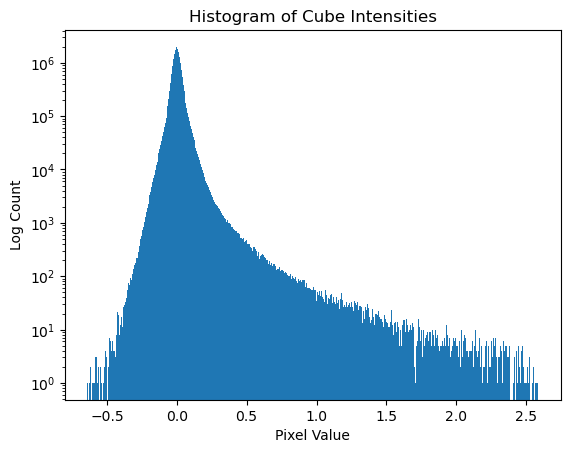

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to one velocity chunk
vel_cube_path = "data/HC3N/HC3N_11-10.fits"
hdul = fits.open(vel_cube_path)
data = hdul[0].data.squeeze()
header = hdul[0].header
wcs = WCS(header)

# Plot histogram to find masking threshold
flattened = data.flatten()
plt.hist(flattened[~np.isnan(flattened)], bins=500, log=True)
plt.xlabel("Pixel Value")
plt.ylabel("Log Count")
plt.title("Histogram of Cube Intensities")
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.io import fits
from astropy.wcs import WCS
import os

def generate_moment_maps(cube_path, molecule_name="HC3N(11-10)", noise_threshold=0.5):
    hdul = fits.open(cube_path)
    cube = hdul[0].data.squeeze()
    header = hdul[0].header
    wcs = WCS(header)

    # Velocity axis
    crval3 = header['CRVAL3']
    cdelt3 = header['CDELT3']
    crpix3 = header['CRPIX3']
    naxis3 = cube.shape[0]
    velocity_axis = crval3 + (np.arange(naxis3) - (crpix3 - 1)) * cdelt3

    # Correct units if needed
    if np.nanmax(velocity_axis) > 1000:
        print("Velocity axis too large, dividing by 1000 to convert m/s to km/s.")
        velocity_axis /= 1000
    print(f"Velocity axis: {velocity_axis[0]:.1f} to {velocity_axis[-1]:.1f} km/s")

    # Apply noise threshold
    filtered_cube = np.where(cube >= noise_threshold, cube, 0)

    # Moment 0
    moment0 = np.nansum(filtered_cube, axis=0)

    # Moment 1
    moment0_safe = np.where(moment0 == 0, np.nan, moment0)
    weighted_cube = filtered_cube * velocity_axis[:, None, None]
    moment1 = np.nansum(weighted_cube, axis=0) / moment0_safe

    # Moment 2
    velocity_diff_sq = (velocity_axis[:, None, None] - moment1) ** 2
    weighted_var_cube = filtered_cube * velocity_diff_sq
    moment2 = np.sqrt(np.nansum(weighted_var_cube, axis=0) / moment0_safe)

    # Output folder
    base_folder = os.path.dirname(cube_path)
    filename_root = os.path.splitext(os.path.basename(cube_path))[0]
    png_path = os.path.join(base_folder, "plots")
    os.makedirs(png_path, exist_ok=True)

    # Custom colormap
    inferno_white = mcolors.LinearSegmentedColormap.from_list(
        "inferno_white",
        ["white", *plt.cm.inferno_r(np.linspace(0, 0.9, 256))]
    )

    # Plotting function
    def plot_moment_map(moment_map, label, title, fname, cmap=inferno_white, vmin=None, vmax=None):
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(projection=wcs, slices=('x', 'y', 0))
        im = ax.imshow(moment_map, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(im, ax=ax, label=label)
        ax.coords[0].set_axislabel('Right Ascension (J2000)')
        ax.coords[1].set_axislabel('Declination (J2000)')
        ax.coords[0].set_major_formatter('hh:mm:ss')
        ax.coords[1].set_major_formatter('dd:mm:ss')
        ax.set_aspect('equal')
        ax.coords[0].set_ticks(spacing=None)
        ax.coords[1].set_ticks(spacing=None)
        plt.title(title)
        plt.savefig(os.path.join(png_path, f"{fname}.png"), dpi=300)
        print(f"Saved {fname}.png")
        plt.close()

    # Plot and save
    plot_moment_map(moment0, "Total Intensity [Jy/beam]",
                    f"0th Moment Map {molecule_name}",
                    f"{filename_root}_moment0")

    plot_moment_map(moment1, "Velocity (km/s)",
                    f"1st Moment Map {molecule_name}",
                    f"{filename_root}_moment1")

    plot_moment_map(moment2, "Velocity Dispersion (km/s)",
                    f"2nd Moment Map {molecule_name} {filename_root}",
                    f"{filename_root}_moment2")

    return moment0, moment1, moment2, header, wcs

generate_moment_maps(vel_cube_path, noise_threshold=0.5)



Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Velocity axis: 227.7 to -220.2 km/s
Saved HC3N_11-10_moment0.png
Saved HC3N_11-10_moment1.png
Saved HC3N_11-10_moment2.png


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(278, 308), dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], shape=(278, 308)),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], shape=(278, 308)),
 SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -3

## **Ok we now have the inital moment maps and the next step is to refine and draw out particular clouds**

This block crops around interesting regions of cloud activity

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import os

def crop_cloud_region(
    fits_path,
    ra_min, ra_max, dec_min, dec_max,
    v_min_kms, v_max_kms,
    label,
    output_dir="data/HC3N/clouds"
):
    """
    Crop a specific cloud region (RA/Dec + velocity) from a FITS cube and save it.

    Args:
        fits_path (str): Path to the velocity-sliced cube.
        ra_min, ra_max (str): RA bounds (e.g. '17:45:04.0')
        dec_min, dec_max (str): Dec bounds (e.g. '-29:04:00')
        v_min_kms, v_max_kms (float): Velocity bounds in km/s.
        label (str): Label for the cloud (e.g. 'cloud_1').
        output_dir (str): Directory to save outputs.

    Returns:
        cropped_cube (np.ndarray), cropped_header (fits.Header)
    """

    # Load FITS data
    hdul = fits.open(fits_path)
    data = hdul[0].data.squeeze()
    header = hdul[0].header
    wcs = WCS(header)

    os.makedirs(output_dir, exist_ok=True)

    # Convert RA/Dec to pixel indices using 2D WCS
    wcs_2d = wcs.celestial
    sky_min = SkyCoord(ra_min, dec_min, unit=(u.hourangle, u.deg))
    sky_max = SkyCoord(ra_max, dec_max, unit=(u.hourangle, u.deg))
    x_min, y_min = wcs_2d.world_to_pixel(sky_min)
    x_max, y_max = wcs_2d.world_to_pixel(sky_max)

    # Sort pixel bounds
    x1, x2 = sorted([int(np.floor(x_min)), int(np.ceil(x_max))])
    y1, y2 = sorted([int(np.floor(y_min)), int(np.ceil(y_max))])

    # Crop spatially
    spatial_crop = data[:, y1:y2, x1:x2]
    spatial_wcs = wcs.slice((slice(None), slice(y1, y2), slice(x1, x2)))
    spatial_header = spatial_wcs.to_header()

    # Get velocity axis (in km/s)
    crval = header['CRVAL3']
    cdelt = header['CDELT3']
    crpix = header['CRPIX3']
    vel_axis = (np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval
    vel_axis_kms = vel_axis / 1000 if np.nanmax(vel_axis) > 1000 else vel_axis

    # Mask velocity range
    mask = (vel_axis_kms >= v_min_kms) & (vel_axis_kms <= v_max_kms)
    if not np.any(mask):
        raise ValueError("No channels in specified velocity range")

    cropped_cube = spatial_crop[mask]
    cropped_header = spatial_header.copy()
    cropped_header['CRVAL3'] = vel_axis[mask][0]
    cropped_header['CRPIX3'] = 1
    cropped_header['CDELT3'] = cdelt

    # Save cropped FITS
    cloud_dir = os.path.join(output_dir, label)
    os.makedirs(cloud_dir, exist_ok=True)
    out_path = os.path.join(cloud_dir, f"{label}_cube.fits")

    fits.writeto(out_path, cropped_cube, cropped_header, overwrite=True)
    print(f"Saved cropped FITS: {out_path}")

    return cropped_cube, cropped_header


## **This block generates the moment map and stats**

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
import numpy as np
import os
import json

def generate_moments_and_stats(
    cube, header, label, save_dir="data/HC3N/clouds", noise_threshold=0.0, show_grid=True
):
    """
    Generate moment 0/1/2 maps, save plots, and return stats for plotting.

    Args:
        cube (np.ndarray): Cropped (v, y, x) cube
        header (fits.Header): FITS header for WCS
        label (str): Cloud label (e.g. 'cloud_1')
        save_dir (str): Where to save plots and stats
        noise_threshold (float): Intensity threshold

    Returns:
        dict: cloud stats (label, RA/Dec center, velocity range, intensity, dispersion)
    """
    cloud_dir = os.path.join(save_dir, label)
    plot_dir = os.path.join(cloud_dir, "plots")
    os.makedirs(plot_dir, exist_ok=True)
    wcs = WCS(header)

    # Velocity axis
    crval = header["CRVAL3"]
    cdelt = header["CDELT3"]
    crpix = header["CRPIX3"]
    v_axis = (np.arange(cube.shape[0]) - (crpix - 1)) * cdelt + crval
    v_axis_kms = v_axis / 1000 if np.nanmax(v_axis) > 1000 else v_axis

    # Apply threshold
    masked = np.where(cube >= noise_threshold, cube, 0)

    # Moment 0
    moment0 = np.nansum(masked, axis=0)

    # Moment 1
    moment0_safe = np.where(moment0 == 0, np.nan, moment0)
    weighted = masked * v_axis_kms[:, None, None]
    moment1 = np.nansum(weighted, axis=0) / moment0_safe

    # Moment 2
    vel_diff2 = (v_axis_kms[:, None, None] - moment1) ** 2
    weighted_var = masked * vel_diff2
    moment2 = np.sqrt(np.nansum(weighted_var, axis=0) / moment0_safe)

    # Save moment maps as PNGs
    cmap = mcolors.LinearSegmentedColormap.from_list("inferno_white", ["white", *plt.cm.inferno_r(np.linspace(0, 0.9, 256))])

    def plot_moment(moment, colorbar_label, title, fname, show_grid=True):
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(projection=wcs, slices=("x", "y", 0))
        im = ax.imshow(moment, origin="lower", cmap=cmap)
        cbar = plt.colorbar(im, ax=ax, label=colorbar_label)
        ax.coords[0].set_axislabel("RA")
        ax.coords[1].set_axislabel("Dec")
        ax.coords[0].set_major_formatter("hh:mm:ss")
        ax.coords[1].set_major_formatter("dd:mm:ss")
        ax.set_aspect("equal")
        if show_grid:
            ax.coords.grid(True, color='grey', ls='--', lw=0.5)
        plt.title(title)
        path = os.path.join(plot_dir, fname)
        plt.savefig(path, dpi=300)
        plt.close()
        print(f"Saved {path}")



    plot_moment(moment0, "Total Intensity [Jy/beam]", f"{label}: Moment 0 HC3N(11-10)", f"{label}_moment0.png", show_grid)
    plot_moment(moment1, "Velocity [km/s]", f"{label}: Moment 1 HC3N(11-10)", f"{label}_moment1.png", show_grid)
    plot_moment(moment2, "Velocity Dispersion [km/s]", f"{label}: Moment 2 HC3N(11-10)", f"{label}_moment2.png", show_grid)


    # Compute stats
    mean_intensity = np.nanmean(moment0)
    mean_dispersion = np.nanmean(moment2)

    # Use 2D WCS to convert center pixel to RA/Dec
    ny, nx = moment0.shape
    center_px = (nx // 2, ny // 2)
    wcs_2d = wcs.celestial
    ra_dec_center = wcs_2d.pixel_to_world(center_px[0], center_px[1])

    ra_str = ra_dec_center.ra.to_string(unit=u.hour, sep=":")
    dec_str = ra_dec_center.dec.to_string(unit=u.deg, sep=":")

    vel_range = (np.min(v_axis_kms), np.max(v_axis_kms))

    stats = {
        "label": label,
        "ra": ra_str,
        "dec": dec_str,
        "velocity_range_kms": vel_range,
        "mean_intensity": float(mean_intensity),
        "mean_dispersion": float(mean_dispersion),
    }

    # Save stats
    stats_path = os.path.join(cloud_dir, f"{label}_stats.json")
    with open(stats_path, "w") as f:
        json.dump(stats, f, indent=2)
    print(f" Saved cloud stats to {stats_path}")

    return moment0, moment1, moment2, wcs, stats



## **This block is used to call the functions and crop out the intersting cloud regions**

In [207]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False  # Prevents LaTeX parsing issues like stray $

cloud = "cloud_25" #CHANGE FIRST
rmax = "17:45:21"
rmin = "17:45:16"
dmax = "-29:00:35"
dmin = "-29:01:10"

vmin = 55
vmax = 66


cropped_cube, cropped_header = crop_cloud_region(
    "data/HC3N/HC3N_11-10.fits",
    ra_min= rmin, ra_max= rmax,
    dec_min= dmin, dec_max= dmax ,
    v_min_kms= vmin, v_max_kms= vmax,
    label= cloud
)

moment0, moment1, moment2, wcs, stats = generate_moments_and_stats(
    cropped_cube, cropped_header, label= cloud, noise_threshold=0.18, show_grid=True
)


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


✅ Saved cropped FITS: data/HC3N/clouds/cloud_25/cloud_25_cube.fits
Saved data/HC3N/clouds/cloud_25/plots/cloud_25_moment0.png
Saved data/HC3N/clouds/cloud_25/plots/cloud_25_moment1.png
Saved data/HC3N/clouds/cloud_25/plots/cloud_25_moment2.png
✅ Saved cloud stats to data/HC3N/clouds/cloud_25/cloud_25_stats.json


## **Ok now we are singulaing individual cores, isolating, so we can get a useful mean intensity and dispersion of the cores**

In [13]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import os

def crop_core_region(
    fits_path,
    ra_min, ra_max, dec_min, dec_max,
    v_min_kms, v_max_kms,
    core_label,
    cloud_label,
    output_dir="data/HC3N/clouds"
):
    """
    Crop a specific core region (RA/Dec + velocity) from a cloud FITS cube.
    """
    # Load FITS
    hdul = fits.open(fits_path)
    data = hdul[0].data.squeeze()
    header = hdul[0].header
    wcs = WCS(header)

    # Make sure core save path exists
    core_dir = os.path.join(output_dir, cloud_label, "cores")
    os.makedirs(core_dir, exist_ok=True)

    # Convert RA/Dec to pixel bounds
    wcs_2d = wcs.celestial
    sky_min = SkyCoord(ra_min, dec_min, unit=(u.hourangle, u.deg))
    sky_max = SkyCoord(ra_max, dec_max, unit=(u.hourangle, u.deg))
    x_min, y_min = wcs_2d.world_to_pixel(sky_min)
    x_max, y_max = wcs_2d.world_to_pixel(sky_max)

    print(f"RA min/max: {ra_min} → {ra_max}")
    print(f"Dec min/max: {dec_min} → {dec_max}")
    print(f"Converted pixels: x = {x_min:.2f} to {x_max:.2f}, y = {y_min:.2f} to {y_max:.2f}")


    # Ensure valid pixel bounds
    x1 = int(np.floor(min(x_min, x_max)))
    x2 = int(np.ceil(max(x_min, x_max)))
    y1 = int(np.floor(min(y_min, y_max)))
    y2 = int(np.ceil(max(y_min, y_max)))

    if x2 == x1:
        x2 += 1
    if y2 == y1:
        y2 += 1

    print(f" RA → x: {x1} to {x2}, Dec → y: {y1} to {y2}")

    # Crop spatially
    spatial_crop = data[:, y1:y2, x1:x2]
    spatial_wcs = wcs.slice((slice(None), slice(y1, y2), slice(x1, x2)))
    spatial_header = spatial_wcs.to_header()

    # Velocity axis (km/s)
    crval = header['CRVAL3']
    cdelt = header['CDELT3']
    crpix = header['CRPIX3']
    vel_axis = (np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval
    vel_axis_kms = vel_axis / 1000 if np.nanmax(vel_axis) > 1000 else vel_axis

    # Mask velocity range
    mask = (vel_axis_kms >= v_min_kms) & (vel_axis_kms <= v_max_kms)
    if not np.any(mask):
        raise ValueError("No channels in specified velocity range")

    cropped_cube = spatial_crop[mask]
    cropped_header = spatial_header.copy()
    cropped_header['CRVAL3'] = vel_axis[mask][0]
    cropped_header['CRPIX3'] = 1
    cropped_header['CDELT3'] = cdelt

    # Save cropped FITS
    out_path = os.path.join(core_dir, f"{core_label}_cube.fits")
    fits.writeto(out_path, cropped_cube, cropped_header, overwrite=True)
    print(f" Saved cropped core FITS: {out_path}")
    print(f" Cropped cube shape: {cropped_cube.shape}")

    return cropped_cube, cropped_header


## **The next cells calcualte the states for each core which will then be used for plotting**

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import os
import json

def generate_core_moments_and_stats(
    cube, header, core_label, cloud_label,
    save_dir="data/HC3N/clouds",
    noise_threshold=0.0,
    intensity_threshold=0.0,
    dispersion_threshold=None,
    show_grid=True
):
    core_dir = os.path.join(save_dir, cloud_label, "cores")
    plot_dir = os.path.join(core_dir, "plots")
    os.makedirs(plot_dir, exist_ok=True)
    wcs = WCS(header)

    # Velocity axis
    crval = header["CRVAL3"]
    cdelt = header["CDELT3"]
    crpix = header["CRPIX3"]
    vel_axis = (np.arange(cube.shape[0]) - (crpix - 1)) * cdelt + crval
    vel_axis_kms = vel_axis / 1000 if np.nanmax(vel_axis) > 1000 else vel_axis

    # Noise threshold masking
    cube_masked = np.where(cube >= noise_threshold, cube, 0)

    # Moment maps
    moment0 = np.nansum(cube_masked, axis=0)
    moment0_safe = np.where(moment0 == 0, np.nan, moment0)

    weighted_vel = cube_masked * vel_axis_kms[:, None, None]
    moment1 = np.nansum(weighted_vel, axis=0) / moment0_safe

    vel_diff2 = (vel_axis_kms[:, None, None] - moment1) ** 2
    weighted_var = cube_masked * vel_diff2
    moment2 = np.sqrt(np.nansum(weighted_var, axis=0) / moment0_safe)

    # Apply intensity & dispersion masks
    if intensity_threshold > 0.0:
        intensity_mask = moment0 >= intensity_threshold
        moment0 = np.where(intensity_mask, moment0, np.nan)
        moment1 = np.where(intensity_mask, moment1, np.nan)
        moment2 = np.where(intensity_mask, moment2, np.nan)

    if dispersion_threshold is not None:
        dispersion_mask = moment2 >= dispersion_threshold
        moment0 = np.where(dispersion_mask, moment0, np.nan)
        moment1 = np.where(dispersion_mask, moment1, np.nan)
        moment2 = np.where(dispersion_mask, moment2, np.nan)

    valid_pixels = np.count_nonzero(~np.isnan(moment0))
    if valid_pixels == 0:
        print(f"⚠️ Core {core_label} in {cloud_label} has no valid voxels after masking → skipping stats.")
        return moment0, moment1, moment2, None

    # Plotting
    cmap = mcolors.LinearSegmentedColormap.from_list("inferno_white", ["white", *plt.cm.inferno_r(np.linspace(0, 0.9, 256))])

    def plot(moment, label_txt, fname):
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(projection=wcs, slices=("x", "y", 0))
        im = ax.imshow(moment, origin="lower", cmap=cmap)
        plt.colorbar(im, ax=ax, label=label_txt)
        ax.set_title(f"{core_label}: {label_txt}")
        ax.coords[0].set_axislabel("RA")
        ax.coords[1].set_axislabel("Dec")
        ax.coords.grid(True, color='grey', ls='--', lw=0.5)
        plt.savefig(os.path.join(plot_dir, fname), dpi=300)
        plt.close()

    plot(moment0, "Moment 0 (Intensity)", f"{core_label}_moment0.png")
    plot(moment1, "Moment 1 (Velocity)", f"{core_label}_moment1.png")
    plot(moment2, "Moment 2 (Dispersion)", f"{core_label}_moment2.png")

    # Stats
    mean_intensity = float(np.nanmean(moment0))
    mean_dispersion = float(np.nanmean(moment2))
    mean_velocity = float(np.nanmean(moment1))
    peak_intensity = float(np.nanmax(moment0))
    min_dispersion = float(np.nanmin(moment2))

    signal_stability = mean_intensity / mean_dispersion if mean_dispersion > 0 else np.nan
    compactness_score = peak_intensity / mean_dispersion if mean_dispersion > 0 else np.nan

    pixel_scale_deg = np.abs(wcs.pixel_scale_matrix[1, 1])
    pixel_scale_arcsec = pixel_scale_deg * 3600
    area_arcsec2 = valid_pixels * pixel_scale_arcsec**2
    radius_arcsec = np.sqrt(area_arcsec2 / np.pi)

    ny, nx = moment0.shape
    center_px = (nx // 2, ny // 2)
    ra_dec = wcs.celestial.pixel_to_world(center_px[0], center_px[1])
    ra_str = ra_dec.ra.to_string(unit=u.hour, sep=":")
    dec_str = ra_dec.dec.to_string(unit=u.deg, sep=":")

    stats = {
        "core_id": core_label,
        "cloud_id": cloud_label,
        "ra": ra_str,
        "dec": dec_str,
        "center_pixel": [int(center_px[0]), int(center_px[1])],
        "velocity_range_kms": (float(np.min(vel_axis_kms)), float(np.max(vel_axis_kms))),
        "mean_velocity": mean_velocity,
        "mean_intensity": mean_intensity,
        "peak_intensity": peak_intensity,
        "mean_dispersion": mean_dispersion,
        "min_dispersion": min_dispersion,
        "num_pixels": valid_pixels,
        "pixel_scale_arcsec": pixel_scale_arcsec,
        "area_arcsec2": area_arcsec2,
        "radius_arcsec": radius_arcsec,
        "signal_stability": signal_stability,
        "compactness_score": compactness_score,
        "noise_threshold": float(noise_threshold),
        "intensity_threshold": float(intensity_threshold),
        "dispersion_threshold": float(dispersion_threshold) if dispersion_threshold is not None else None
    }

    # Confirm before saving
    print("\n Confirm core details before saving:")
    print(f"  → Cloud ID: {cloud_label}")
    print(f"  → Core ID:  {core_label}")
    print(f"  → Save to:  {os.path.join(core_dir, f'{core_label}_stats.json')}")
    confirm = input(" Confirm these IDs? Type 'yes' to proceed: ").strip().lower()

    if confirm != "yes":
        print(" Cancelled — core not saved.")
        return moment0, moment1, moment2, None

    # Save stats
    stats_path = os.path.join(core_dir, f"{core_label}_stats.json")
    with open(stats_path, "w") as f:
        json.dump(stats, f, indent=2)
    print(f" Saved core stats to {stats_path}")

    return moment0, moment1, moment2, stats


In [18]:
if core_stats is not None:
    def update_cores_master_json(core_stats, master_path="data/HC3N/clouds/cores_master.json"):
        """
        Append or update a core's stats in the master JSON.
        """
        import json
        from pathlib import Path

        if Path(master_path).exists():
            with open(master_path, "r") as f:
                all_cores = json.load(f)
        else:
            all_cores = []

        # Remove previous entry for this core (if exists)
        all_cores = [c for c in all_cores if not (
            c["cloud_id"] == core_stats["cloud_id"] and c["core_id"] == core_stats["core_id"]
        )]

        all_cores.append(core_stats)

        with open(master_path, "w") as f:
            json.dump(all_cores, f, indent=2)
        
        print(f"Updated master JSON with {core_stats['core_id']} from {core_stats['cloud_id']}")


## **Following code is used to plot the energy proxy**

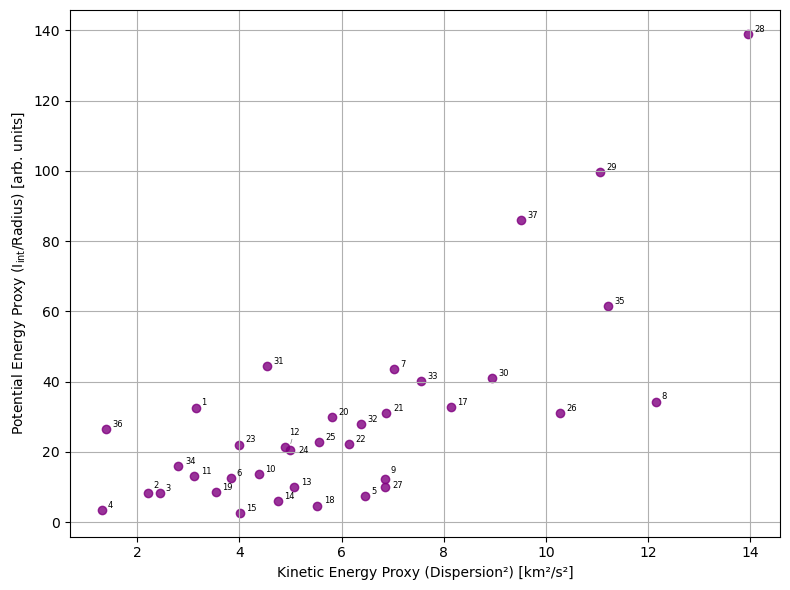

In [8]:
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_energy_proxies_smart_labels(json_path="data/HC3N/clouds/cores_master.json", save_path=None):
    with open(json_path, "r") as f:
        core_data = json.load(f)

    kinetic_energy = []
    potential_energy = []
    labels = []

    for core in core_data:
        try:
            mean_intensity = core["mean_intensity"]
            num_pixels = core["num_pixels"]
            radius_arcsec = core["radius_arcsec"]
            dispersion = core["mean_dispersion"]

            if radius_arcsec > 0 and num_pixels > 0 and dispersion > 0:
                I_int = mean_intensity * num_pixels
                E_pot = I_int / radius_arcsec
                E_kin = dispersion ** 2

                kinetic_energy.append(E_kin)
                potential_energy.append(E_pot)
                labels.append(core['core_id'].split('_')[-1])
        except (KeyError, TypeError):
            continue

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(kinetic_energy, potential_energy, color='purple', alpha=0.8)

    # Build text labels
    texts = []
    offset = 0.1  # ⬅️ adjust this if needed (e.g. 0.3 or 0.25)

    for x, y, label in zip(kinetic_energy, potential_energy, labels):
        texts.append(ax.text(x + offset, y + offset, label, fontsize=6))


    # Adjust text to avoid overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    ax.set_xlabel("Kinetic Energy Proxy (Dispersion²) [km²/s²]")
    ax.set_ylabel("Potential Energy Proxy (I$_{\\rm int}$/Radius) [arb. units]")
    ax.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f" Saved plot to {save_path}")
    else:
        plt.show()

# Example call
plot_energy_proxies_smart_labels(
)



## **The next cell hihglights the most gravitationally dominant regions and plots the trend line**

Slope of fitted line: 8.847
Intercept of fitted line: 7.161


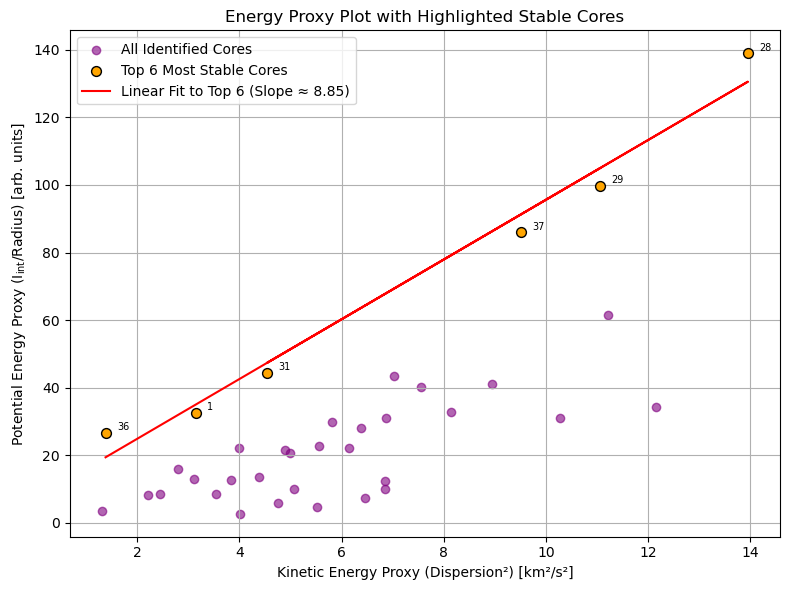

In [8]:
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np

def plot_energy_proxies_with_highlights(
    json_path="data/HC3N/clouds/cores_master.json",
    save_path=None,
    top_n=6,
    fit_trend=True
):
    with open(json_path, "r") as f:
        core_data = json.load(f)

    cores = []
    for core in core_data:
        try:
            mean_intensity = core["mean_intensity"]
            num_pixels = core["num_pixels"]
            radius_arcsec = core["radius_arcsec"]
            dispersion = core["mean_dispersion"]
            core_id = core['core_id'].split('_')[-1]

            if radius_arcsec > 0 and num_pixels > 0 and dispersion > 0:
                I_int = mean_intensity * num_pixels
                E_pot = I_int / radius_arcsec
                E_kin = dispersion ** 2
                ratio = abs(E_pot) / E_kin

                cores.append({
                    "core_id": core_id,
                    "E_kin": E_kin,
                    "E_pot": E_pot,
                    "ratio": ratio
                })

        except (KeyError, TypeError):
            continue

    # Sort and get top N by PE/KE ratio
    cores_sorted = sorted(cores, key=lambda x: x["ratio"], reverse=True)
    top_cores = cores_sorted[:top_n]
    top_ids = set(c["core_id"] for c in top_cores)

    # Prepare plot data
    x_all = [c["E_kin"] for c in cores]
    y_all = [c["E_pot"] for c in cores]
    labels = [c["core_id"] for c in cores]

    # Separate top cores and others
    other_cores = [c for c in cores if c["core_id"] not in top_ids]
    x_other = [c["E_kin"] for c in other_cores]
    y_other = [c["E_pot"] for c in other_cores]

    x_top_plot = [c["E_kin"] for c in top_cores]
    y_top_plot = [c["E_pot"] for c in top_cores]

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot all other cores
    ax.scatter(x_other, y_other, color='purple', alpha=0.6, label='All Identified Cores')

    # Plot top_n highlighted cores
    ax.scatter(x_top_plot, y_top_plot, color='orange', edgecolor='black', s=50, zorder=3, label='Top 6 Most Stable Cores')

    # Optional: fit a trend line through top cores
    if fit_trend:
        coeffs = np.polyfit(x_top_plot, y_top_plot, deg=1)
        slope, intercept = coeffs

        print(f"Slope of fitted line: {slope:.3f}")
        print(f"Intercept of fitted line: {intercept:.3f}")

        ax.plot(x_top_plot, np.polyval(coeffs, x_top_plot), color='red', linestyle='-', label=f'Linear Fit to Top 6 (Slope ≈ {slope:.2f})')

    # Adjust text labels
    texts = []
    offset = 0.2  # Adjust label offset if needed

    for x, y, label in zip(x_top_plot, y_top_plot, [c["core_id"] for c in top_cores]):
        texts.append(ax.text(x + offset, y + offset, label, fontsize=7))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # Labels, grid, layout
    ax.set_xlabel("Kinetic Energy Proxy (Dispersion²) [km²/s²]")
    ax.set_ylabel("Potential Energy Proxy (I$_{\\rm int}$/Radius) [arb. units]")
    ax.set_title("Energy Proxy Plot with Highlighted Stable Cores")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f" Saved plot to {save_path}")
    else:
        plt.show()

# Example usage
plot_energy_proxies_with_highlights(
    top_n=6,
    fit_trend=True
)
